In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (LabelEncoder, FunctionTransformer)
from sklearn.compose import ColumnTransformer
import pickle

%matplotlib inline

## EDA

In [2]:
# Create feature and target dataframes
# The source dataset already had this split into two files
X = pd.read_csv('data/source_data/training_set_features.csv')
y = pd.read_csv('data/source_data/training_set_labels.csv')

The `training_set_labels.csv` file read to `y` contains two target variables, `h1n1_vaccine` and `seasonal_vaccine1`. For this project only the `h1n1_vaccine` target variable will be used.

In [3]:
# Sets target variable
y = y.h1n1_vaccine

### Feature Analysis

In [4]:
# preview of feature dataframe
print(X.shape)
X.head()

(26707, 36)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


Our dataset has 16707 entries and 36 features.

In [5]:
# preview at feature column information
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

Dataset contains features of multiple types, a lot of them appear to be categorical.

There also appears to be a lot of missing values in this dataframe. Let's check the amount for each feature.

In [6]:
# Checks amount of Nan values in feature dataframe
X.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

The majority of our features contain missing values that will need to be handled. Three features, (`health_insurance`, `employment_industry`, and `employment_occupation`), are missing values for about half of their entries and will most likely be dropped from the dataset. If our future models perform poorly filling these features in using a regression model, filling in by ratio of occurences in other entries, or finding a quick correlation between them and other features can be used to fill them in.

The feature `respondent_id` will also be dropped as it has no use in our model.

In [7]:
# Drops columns containing many missing entries
X_mod = X.drop(columns = ['respondent_id', 
                      'health_insurance', 
                      'employment_industry', 
                      'employment_occupation'], 
           axis=1).copy()

Next lets check which or our numerical type features are continuous or categorical using scatterplots. 

In [8]:
X_num = X_mod.select_dtypes(include=['int64', 'float64'])

def scatter_plots(X, n_cols, y='index'):
    '''
    Creates scatter plots for each feature in X against y
    Handles missing values of type Nan 
    
    Inputs: X = dataframe to have features plotted
            y = dataseries to be plotted against,
                default=index
            ncols = number of columns for figure
    Output: [# of features//ncols, ncols] sized figure of scatterplots
    '''
#     Calculates number of rows in figure
    n_rows = (X.shape[1]//n_cols)+1
    
#     Creates figure
    fig, axes = plt.subplots(figsize = (n_cols*5, n_rows*5),
                                  ncols=n_cols,
                                  nrows=n_rows);
#     Plots individual scatter plots
    for i, col in enumerate(X.columns):
        if type(y) == str:
            ind = range(X[col].notna().sum())
            axes[i//n_cols, i%n_cols].scatter(ind, X[col].dropna());
            axes[i//n_cols, i%n_cols].set_title(f'{col} vs. {y}');
        else:
            temp_df = pd.concat([X[col], y], axis=1).dropna()
            axes[i//n_cols, i%n_cols].scatter(temp_df.iloc[:,1], temp_df.iloc[:,0]);
            axes[i//n_cols, i%n_cols].set_title(f'{col} vs. {y.name}');
                        

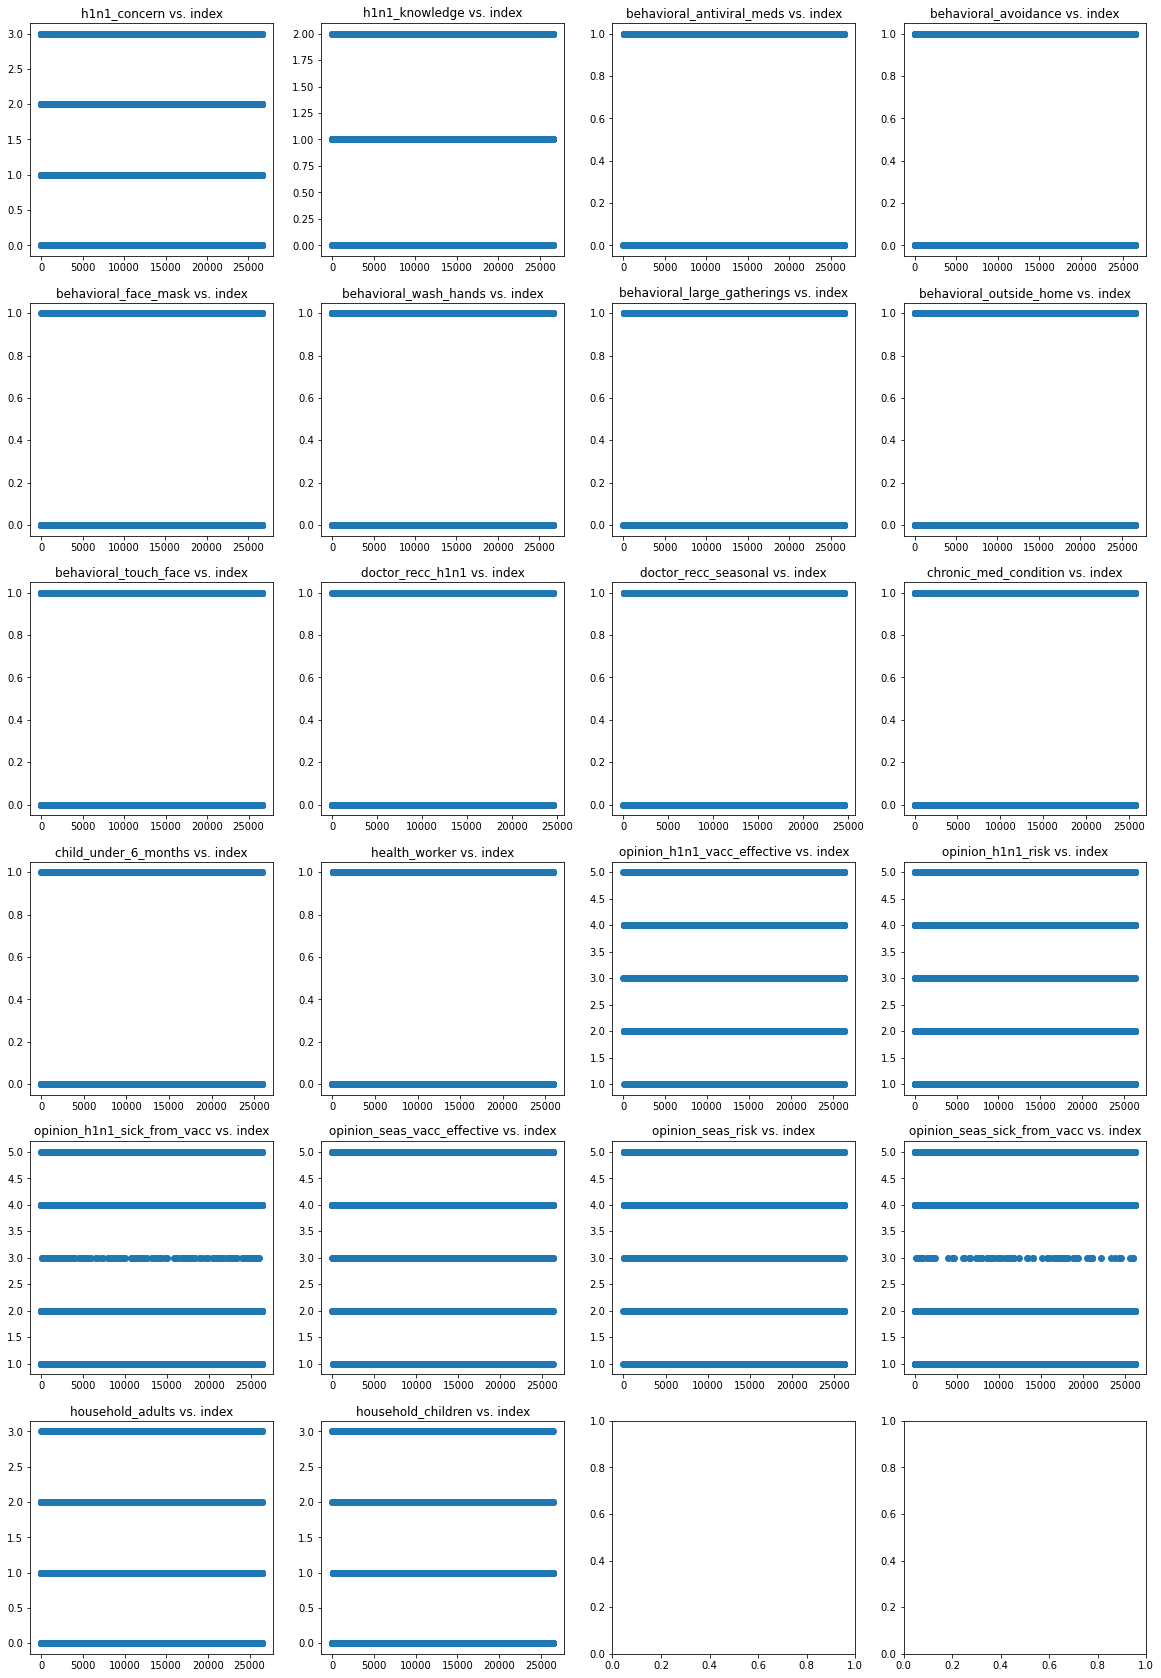

In [9]:
scatter_plots(X_num, 4)

It appears that all of our features can be considered categorical. Now lets try and determine how to handle the missing values. 

Though lets first determine if any of our rows are missing a lot of information.

In [10]:
# Creates a list with number of missing values in each row
nan_per_row = []
for i in range(len(X_mod)):
    nan_per_row.append(X_mod.iloc[i,:].isna().sum())

In [11]:
# creates dataseries
nan_per_row_ds = pd.Series(nan_per_row)

# gets number of rows with each amount of missing values
nan_row_counts = nan_per_row_ds.value_counts()

In [12]:
# Prints the number of occurences in order from most nans in row to least
ordered_missing_nan = nan_row_counts[nan_row_counts.keys().sort_values(ascending=False)]
ordered_missing_nan

19        2
18       41
17       13
16      136
15       14
14      125
13       39
12       49
11       48
10       97
9        56
8       154
7        86
6        44
5       385
4       138
3       509
2      2227
1      2902
0     19642
dtype: int64

In [13]:
np.cumsum(ordered_missing_nan)

19        2
18       43
17       56
16      192
15      206
14      331
13      370
12      419
11      467
10      564
9       620
8       774
7       860
6       904
5      1289
4      1427
3      1936
2      4163
1      7065
0     26707
dtype: int64

Our current features dataframe has 32 features after dropping those four columns. That means around 467 entries are missing about a third (11 values) of their features information. Since these entries are missing most of their information lets drop them from the dataset.

In [14]:
nan_per_row_ds[nan_per_row_ds >= 11].index

Int64Index([   64,   183,   203,   269,   410,   562,   570,   587,   645,
              692,
            ...
            25783, 25843, 25979, 26161, 26223, 26274, 26526, 26549, 26608,
            26672],
           dtype='int64', length=467)

In [15]:
# Grabs index values for rows to be dropped
many_nans_index = nan_per_row_ds[nan_per_row_ds >= 11].index

# drops entries from features and target
X_mod = X_mod.drop(many_nans_index)
y_mod = y.drop(many_nans_index)

In [16]:
X_mod.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children'],
      dtype='object')

In [17]:
X_mod.shape

(26240, 32)

In [18]:
X_mod.isna().sum()

h1n1_concern                     83
h1n1_knowledge                  109
behavioral_antiviral_meds        68
behavioral_avoidance            201
behavioral_face_mask             17
behavioral_wash_hands            35
behavioral_large_gatherings      83
behavioral_outside_home          81
behavioral_touch_face           121
doctor_recc_h1n1               1988
doctor_recc_seasonal           1988
chronic_med_condition           505
child_under_6_months            353
health_worker                   337
opinion_h1n1_vacc_effective      94
opinion_h1n1_risk                48
opinion_h1n1_sick_from_vacc      16
opinion_seas_vacc_effective      47
opinion_seas_risk                76
opinion_seas_sick_from_vacc      80
age_group                         0
education                       940
race                              0
sex                               0
income_poverty                 3956
marital_status                  941
rent_or_own                    1575
employment_status           

In [19]:
# Quick statistical measures for numerical features
X_mod.iloc[:, :11].describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal
count,26157.000000,26131.000000,26172.000000,26039.000000,26223.000000,26205.000000,26157.000000,26159.000000,26119.000000,24252.000000,24252.000000
mean,1.618496,1.269182,0.048067,0.727140,0.067956,0.825682,0.357839,0.336175,0.677782,0.221013,0.330859
std,0.907480,0.614488,0.213911,0.445438,0.251675,0.379390,0.479374,0.472409,0.467335,0.414938,0.470532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
X_mod.iloc[:, 11:].describe()

,chronic_med_condition,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,25735.000000,25887.000000,25903.000000,26146.000000,26192.000000,26224.000000,26193.000000,26164.000000,26160.000000,26143.000000,26143.000000
mean,0.283272,0.082590,0.111918,3.852865,2.343235,2.358679,4.027259,2.719768,2.118234,0.887427,0.534407
std,0.450596,0.275266,0.315271,1.006291,1.286026,1.363084,1.085891,1.385260,1.333139,0.752872,0.927871
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,1.000000,0.000000,0.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [21]:
# corr_dict = {}
# cols = X_mod.columns
# for i in range(X_mod.shape[1] - 1):
#     for j in range(i+1,X_mod.shape[1]):
#         key1 = cols[i] + '_+_' + cols[j]
#         corr_dict[key1] = {}
#         for k in range(X_mod.shape[0]):
#             col1_val = X_mod.iloc[k, i]
#             col2_val = X_mod.iloc[k, j]
            
#             key2 = str(col1_val) + '_+_' + str(col2_val)
#             corr_dict[key1][key2] = corr_dict[key1].get(key2, 0)+1

In [22]:
# corr_dict[list(corr_dict.keys())[0]]

1. Create a random implementation for missing values, in new columns
2. iteratively use logistic regression to predict values for missing entries

Need to convert objects to numbers.

Before we start to classify the missing values, the object columns need to be trasnformed to numeric.

Label Encoder can't handle Nan values, so run an iterative function that will save indices for Null values, then drop, then use labelencoder, then add null values to transformed set, then concat all dataseries

In [23]:
def feature_encoder(df):
    '''
    Takes in a dataframe and uses LabelEncoder on non-Nan values in each feature
    
    Input: df = DataFrame
    Output: dataframe with Nan values and encoded non-Nan values
    '''
    
#     Iterates through each feature and encodes non-Nan values
    for feature in df.columns:
        df.loc[df[feature].notnull(), feature] = LabelEncoder().fit_transform(df.loc[df[feature].notnull(), feature])
    return df

In [24]:
# Creatures custom encoder function transformer
Encoder_FT = FunctionTransformer(feature_encoder)

In [25]:
# Grabs object feature column names to be encoded
object_cols = list(X_mod.select_dtypes('object').columns)

# Creates Column Transformer with custom encoder function transformer
Encoder_CT = ColumnTransformer(transformers = [('encoder', Encoder_FT, object_cols)],
                       remainder='passthrough')

In [27]:
# Runs ColumnTransformer on feature dataset
X_mod_encoded = Encoder_CT.fit_transform(X_mod)

In [28]:
# Creates Dataframe using encoded dataset
X_mod_encoded = pd.DataFrame(X_mod_encoded,
                             index = X_mod.index,
                             columns = X_mod.columns)
X_mod_encoded.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
0,3,1,3,0,2,1,0,1,8,2,...,0,0,3,1,2,2,1,2,0,0
1,1,0,3,1,2,1,1,0,1,0,...,0,0,5,4,4,4,2,4,0,0
2,0,2,3,1,0,1,0,0,9,0,...,0,0,3,1,1,4,1,2,2,0
3,4,0,3,0,2,1,1,1,5,1,...,0,0,3,3,5,5,4,1,0,0
4,2,3,3,0,0,0,0,0,9,0,...,0,0,3,3,2,3,1,4,1,0


In [29]:
# Saves X_mod_encoded to pickle file for ease to reload
with open('data/temp_pickle_files/X_mod_encoded.pickle', 'wb') as f:
    pickle.dump(X_mod_encoded, f)

In [30]:
# Opens X_mod_encoded pickle file
with open('data/temp_pickle_files/X_mod_encoded.pickle', 'rb') as f:
    X_mod_encoded = pickle.load(f)

In [ ]:
# def random_imputation(df, feature):
#     '''
#     Fills in missing feature data by randomly imputing existing values by
#     occurence rate
#     '''
    
#     number_missing = df[feature].isnull().sum()
#     observed_values = df.loc[df[feature].notnull(), feature]
#     df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
#     return df

In [32]:
def random_imputation(df):
    for col in df.columns:
        df[col+'_imp'] = df[col]
        number_missing = df[col].isnull().sum()
        observed_values = df.loc[df[col].notnull(), col]
        df.loc[df[col].isnull(), col+'_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    return df

In [33]:
Rand_Imputer_FT = FunctionTransformer(random_imputation)

In [34]:
nan_amount = X_mod_encoded.isna().sum()
missing_columns = nan_amount[nan_amount>0].index
missing_columns

Index(['h1n1_knowledge', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months',
       'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children'],
      dtype='object')

In [72]:
nan_amount

h1n1_concern                      0
h1n1_knowledge                  940
behavioral_antiviral_meds         0
behavioral_avoidance              0
behavioral_face_mask           3956
behavioral_wash_hands           941
behavioral_large_gatherings    1575
behavioral_outside_home         996
behavioral_touch_face             0
doctor_recc_h1n1                  0
doctor_recc_seasonal             83
chronic_med_condition           109
child_under_6_months             68
health_worker                   201
opinion_h1n1_vacc_effective      17
opinion_h1n1_risk                35
opinion_h1n1_sick_from_vacc      83
opinion_seas_vacc_effective      81
opinion_seas_risk               121
opinion_seas_sick_from_vacc    1988
age_group                      1988
education                       505
race                            353
sex                             337
income_poverty                   94
marital_status                   48
rent_or_own                      16
employment_status           

In [35]:
Imputer_CT = ColumnTransformer([('rand_imputer', Rand_Imputer_FT, missing_columns)],
                               remainder='passthrough')

In [47]:
X_mod_imputed = Imputer_CT.fit_transform(X_mod_encoded)

In [37]:
X_mod_imputed.shape

(26240, 59)

In [49]:
all_columns = list(X_mod.columns)
for col in missing_columns:
    all_columns.append(col+'_imp')

In [50]:
df_X_mod_imputed = pd.DataFrame(X_mod_imputed,
                                index=X_mod.index,
                                columns=all_columns)
df_X_mod_imputed.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race_imp,sex_imp,income_poverty_imp,marital_status_imp,rent_or_own_imp,employment_status_imp,hhs_geo_region_imp,census_msa_imp,household_adults_imp,household_children_imp
0,1,2,1,0,1,1,0,0,0,0,...,2,1,2,0,0,3,3,0,8,2
1,0,2,1,1,0,3,2,0,1,0,...,4,2,4,0,0,1,3,1,1,0
2,2,0,1,0,0,1,1,0,1,0,...,4,1,2,2,0,0,3,1,9,0
3,0,2,1,1,1,1,1,0,1,0,...,5,4,1,0,0,4,3,0,5,1
4,3,0,0,0,0,2,1,0,1,0,...,3,1,4,1,0,2,3,0,9,0


In [73]:
# I think the transformer is mixing up columns, try and see if columns equal each other.

In [70]:
df_X_mod_imputed.drop(missing_columns, axis=1).isna().sum()

h1n1_concern                        940
behavioral_antiviral_meds           941
behavioral_avoidance               1575
behavioral_touch_face               201
doctor_recc_h1n1                     17
h1n1_knowledge_imp                    0
behavioral_face_mask_imp              0
behavioral_wash_hands_imp             0
behavioral_large_gatherings_imp       0
behavioral_outside_home_imp           0
doctor_recc_seasonal_imp              0
chronic_med_condition_imp             0
child_under_6_months_imp              0
health_worker_imp                     0
opinion_h1n1_vacc_effective_imp       0
opinion_h1n1_risk_imp                 0
opinion_h1n1_sick_from_vacc_imp       0
opinion_seas_vacc_effective_imp       0
opinion_seas_risk_imp                 0
opinion_seas_sick_from_vacc_imp       0
age_group_imp                         0
education_imp                         0
race_imp                              0
sex_imp                               0
income_poverty_imp                    0


In [ ]:
# for feature in missing_columns:
#     X_mod_encoded[feature + '_imp'] = X_mod_encoded[feature]
#     X_mod_encoded = random_imputation(X_mod_encoded, feature)

In [ ]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = X_mod_encoded[feature + "_imp"]
    parameters = list(set(X_mod_encoded.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = LogisticRegression(random_state=42)
    model.fit(X = X_mod_encoded[parameters], y = X_mod_encoded[feature + '_imp'])
    
    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[X_mod_encoded[feature].isnull(), "Det" + feature] = model.predict(X_mod_encoded[parameters])[X_mod_encoded[feature].isnull()]

In [ ]:
X_mod.iloc[:,12:].describe()

In [ ]:
# Preview target dataframe
y.head()